<a href="https://colab.research.google.com/github/audlr/inUniv_DS/blob/main/%ED%86%B5%ED%95%A9_%EC%B5%9C%EC%A2%851.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sqlalchemy.sql.elements import Null
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Preprocessing

**Handling missing values**

In [142]:
def prep(file): 
  # Read csv file
  df = pd.read_csv(file)

  if 'country_destination' in df.columns:
    #Remove row 'NDF' in country_destination
    cd_ndf=df[df['country_destination']=='NDF'].index
    df.drop(labels=cd_ndf,inplace=True)

  # Cleaning dirty train_data - Missing Data
  df.replace(['-unknown-', 'OTHER', 'nan', 0], np.nan, inplace=True)
  #Cleaning dirty train_data - Outlier data
  df['age'] = df['age'].apply(lambda x: np.nan if x > 100 else x)

  return df

visualization

Chose mode()

In [143]:
#bfill substitution

def bfill(df):
  df.fillna(method='bfill', inplace=True)
  #drop low data that is not filled with bfill
  df.dropna(how='any',axis=0, inplace=True)

  return df

In [144]:
#ffill substitution
def ffill(df):
  df.fillna(method='ffill', inplace=True)
  #drop low data that is not filled with ffill
  df.dropna(how='any', axis=0, inplace=True)

  return df

In [145]:
#mode substitution

def mode(df):
  for column in ['gender', 'age', 'language', 'signup_flow']:
      mode_values = df[column].mode()
      if len(mode_values) > 0:
          mode_value = mode_values[0]
          df[column].fillna(mode_value, inplace=True)
  
  return df

In [146]:
#mean substitution (gender value use mode)

def mean(df):
  for column in ['age', 'signup_flow']:
    average_value = df[column].mean()
    df[column].fillna(average_value, inplace=True)

  mode_values = df['gender', 'language'].mode()
  if len(mode_values) > 0:
    mode_value = mode_values[0]
    df['gender'].fillna(mode_value, inplace=True)

**Encoding** : Choose one

In [147]:
# label encoding

def label_encoder(df):
  label_encoder = LabelEncoder()
  categorical_cols = ['gender', 'language']

  # Label encoded columns of categorical_cols
  for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col].values.ravel())

  return df

In [148]:
# Ordinal Encoding

def ordinal_encoder(df):
  ordinal_encoder = OrdinalEncoder()
  categorical_cols = ['gender', 'language']

  for col in categorical_cols:
    df[col] = ordinal_encoder.fit_transform(df[[col]].values.reshape(-1, 1))
  
  return df

In [149]:
# One-hot Encoding : trash

def onehot_encoder(df):
  onehot_encoder = OneHotEncoder()
  categorical_cols = ['gender', 'language']

  # One-hot encoded columns of categorical_cols
  encoded_cols = []
  for col in categorical_cols:
      encoded_matrix = onehot_encoder.fit_transform(df[[col]]).toarray()
      categories = onehot_encoder.categories_[0]
      for i, category in enumerate(categories):
          encoded_col = col + '_' + str(category)
          df[encoded_col] = encoded_matrix[:, i]
          encoded_cols.append(encoded_col)

  return df

**Scaling** : Choose one

In [150]:
def standard_scaler(df):
  numeric_cols = ['age', 'signup_flow']
  df[numeric_cols] = StandardScaler().fit_transform(df[numeric_cols])

  return df

In [151]:
def minmax_scaler(df):
  numeric_cols = ['age', 'signup_flow']
  df[numeric_cols] = MinMaxScaler().fit_transform(df[numeric_cols])

  return df

In [152]:
def robust_scaler(df):
  numeric_cols = ['age', 'signup_flow']
  df[numeric_cols] = RobustScaler().fit_transform(df[numeric_cols])

  return df

# Learning models

Choose one

In [153]:
#logistic regression model (without k-fold)

def logistic_regression(X_train, X_test, y_train, y_test):
  model = LogisticRegression(solver='liblinear')
  model.fit(X_train, y_train)

  # Model Evaluation
  y_pred = model.predict(X_train)
  accuracy = accuracy_score(y_train, y_pred)

  return accuracy

In [154]:
# decision tree model

def decision_tree(X_train, X_test, y_train, y_test):

  # Decision Tree Model
  model = DecisionTreeClassifier()
  model.fit(X_train, y_train)

  # Model Evaluation
  y_pred = model.predict(X_train)
  accuracy = accuracy_score(y_train, y_pred)

  return accuracy

# Find the best combination

**Grid Search**

In [175]:
def decision_tree_grid_search(train_data, target_data, encoders, scalers):
    results = []

    for encoder in encoders:
        for scaler in scalers:
            train_data_encoded = encoder(train_data)
            train_data_scaled = scaler(train_data_encoded)

            # Define the model to use
            model = DecisionTreeClassifier()

            # Define the parameter grid for grid search
            param_grid = {
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 4, 6],
                'min_samples_leaf': [1, 2, 3]
            }

            # Perform grid search with k-fold cross-validation
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
            grid_search.fit(train_data_scaled, target_data)

            # Store the encoder, scaler, accuracy, and parameters
            result = {
                'encoder': encoder,
                'scaler': scaler,
                'accuracy': grid_search.best_score_,
                'params': grid_search.best_params_
            }
            results.append(result)

    # Sort the results based on accuracy and select the top n combinations
    results = sorted(results, key=lambda x: x['accuracy'], reverse=True)[:5]
    return results

In [178]:
#Find best ombination to use Grid Search (use logistic regression)
def logistic_regression_grid_search(train_data, target_data, encoders, scalers):
    results = []
    
    for encoder in encoders:
        for scaler in scalers:
            train_data_encoded = encoder(train_data)
            train_data_scaled = scaler(train_data_encoded)

            # Define the logistic regression model
            model = LogisticRegression(solver='liblinear')

            # Define the parameter grid for grid search
            param_grid = {
                'C': [0.01, 0.1, 1.0],
                'penalty': ['l1', 'l2']
            }

            # Perform grid search with k-fold cross-validation
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
            grid_search.fit(train_data_scaled, target_data)

            # Store the encoder, scaler, and accuracy
            result = {
                'encoder': encoder,
                'scaler': scaler,
                'accuracy': grid_search.best_score_
            }
            results.append(result)

    # Return the top 5 combinations based on accuracy
    results = sorted(results, key=lambda x: x['accuracy'], reverse=True)[:5]
    return results

In [179]:
df = mode(prep('train_users_2.csv'))

#Extract columns to use
use_columns = ['gender', 'age', 'language', 'signup_flow']
target_column = ['country_destination']

train_data = df.loc[:, use_columns]
target_data = df.loc[:, target_column]

X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.2, random_state=42)

# Define the encoders and scalers to try
encoders = [label_encoder, ordinal_encoder]
scalers = [standard_scaler, minmax_scaler, robust_scaler]

# Perform grid search to find the top 5 encoder and scaler combinations for logistic regression
top_5_results = logistic_regression_grid_search(X_train, y_train, encoders, scalers)

# Print the top 5 combinations
for i, result in enumerate(top_5_results):
    print(f"Rank {i+1}:")
    print("Encoder:", result['encoder'])
    print("Scaler:", result['scaler'])
    print("Accuracy:", result['accuracy'])
    print()

# Perform grid search to find the top 5 encoder, scaler, and parameter combinations
top_5_results = decision_tree_grid_search(train_data, target_data, encoders, scalers)

# Print the top 5 combinations
for i, result in enumerate(top_5_results):
    print(f"Rank {i+1}:")
    print("Encoder:", result['encoder'])
    print("Scaler:", result['scaler'])
    print("Accuracy:", result['accuracy'])
    print("Parameters:", result['params'])
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

Rank 1:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function standard_scaler at 0x7f0d8c623010>
Accuracy: 0.7020077053895477

Rank 2:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function minmax_scaler at 0x7f0d91ad69e0>
Accuracy: 0.7020077053895477

Rank 3:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function robust_scaler at 0x7f0d919376d0>
Accuracy: 0.7020077053895477

Rank 4:
Encoder: <function ordinal_encoder at 0x7f0d8c622950>
Scaler: <function standard_scaler at 0x7f0d8c623010>
Accuracy: 0.7020077053895477

Rank 5:
Encoder: <function ordinal_encoder at 0x7f0d8c622950>
Scaler: <function minmax_scaler at 0x7f0d91ad69e0>
Accuracy: 0.7020077053895477

Rank 1:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function standard_scaler at 0x7f0d8c623010>
Accuracy: 0.7014329423234059
Parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Rank 2:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: 

**Logistic Regression**

Rank 1:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function standard_scaler at 0x7f0d8c623010>
Accuracy: 0.7020077053895477

Rank 2:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function minmax_scaler at 0x7f0d91ad69e0>
Accuracy: 0.7020077053895477

Rank 3:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function robust_scaler at 0x7f0d919376d0>
Accuracy: 0.7020077053895477

Rank 4:
Encoder: <function ordinal_encoder at 0x7f0d8c622950>
Scaler: <function standard_scaler at 0x7f0d8c623010>
Accuracy: 0.7020077053895477

Rank 5:
Encoder: <function ordinal_encoder at 0x7f0d8c622950>
Scaler: <function minmax_scaler at 0x7f0d91ad69e0>
Accuracy: 0.7020077053895477

**Decision Tree**

Rank 1:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function standard_scaler at 0x7f0d8c623010>
Accuracy: 0.7014329423234059
Parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Rank 2:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function minmax_scaler at 0x7f0d91ad69e0>
Accuracy: 0.7014329423234059
Parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Rank 3:
Encoder: <function label_encoder at 0x7f0d8c6224d0>
Scaler: <function robust_scaler at 0x7f0d919376d0>
Accuracy: 0.7014329423234059
Parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Rank 4:
Encoder: <function ordinal_encoder at 0x7f0d8c622950>
Scaler: <function standard_scaler at 0x7f0d8c623010>
Accuracy: 0.7014329423234059
Parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Rank 5:
Encoder: <function ordinal_encoder at 0x7f0d8c622950>
Scaler: <function minmax_scaler at 0x7f0d91ad69e0>
Accuracy: 0.7014329423234059
Parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

# Visualization

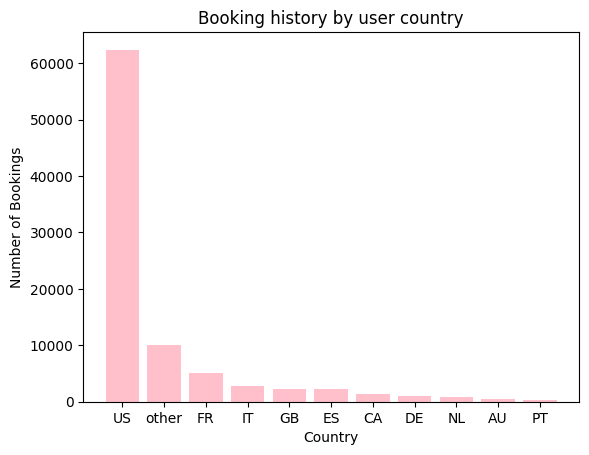

In [180]:
country=df.groupby('country_destination').count().sort_values(by='id',ascending=False)
plt.bar(country.index,country['id'],color='pink')
plt.xlabel('Country')
plt.ylabel('Number of Bookings')
plt.title('Booking history by user country')
plt.show();

# Distribution of customers by age
fig=px.histogram(train_data,x='age',color='gender',title='Distribution of Age')
fig.show();

# Customer Language
fig=px.histogram(train_data,x='language',color='gender',title='Language Spoken')
fig.update_layout(bargap=0.1)
fig.show();

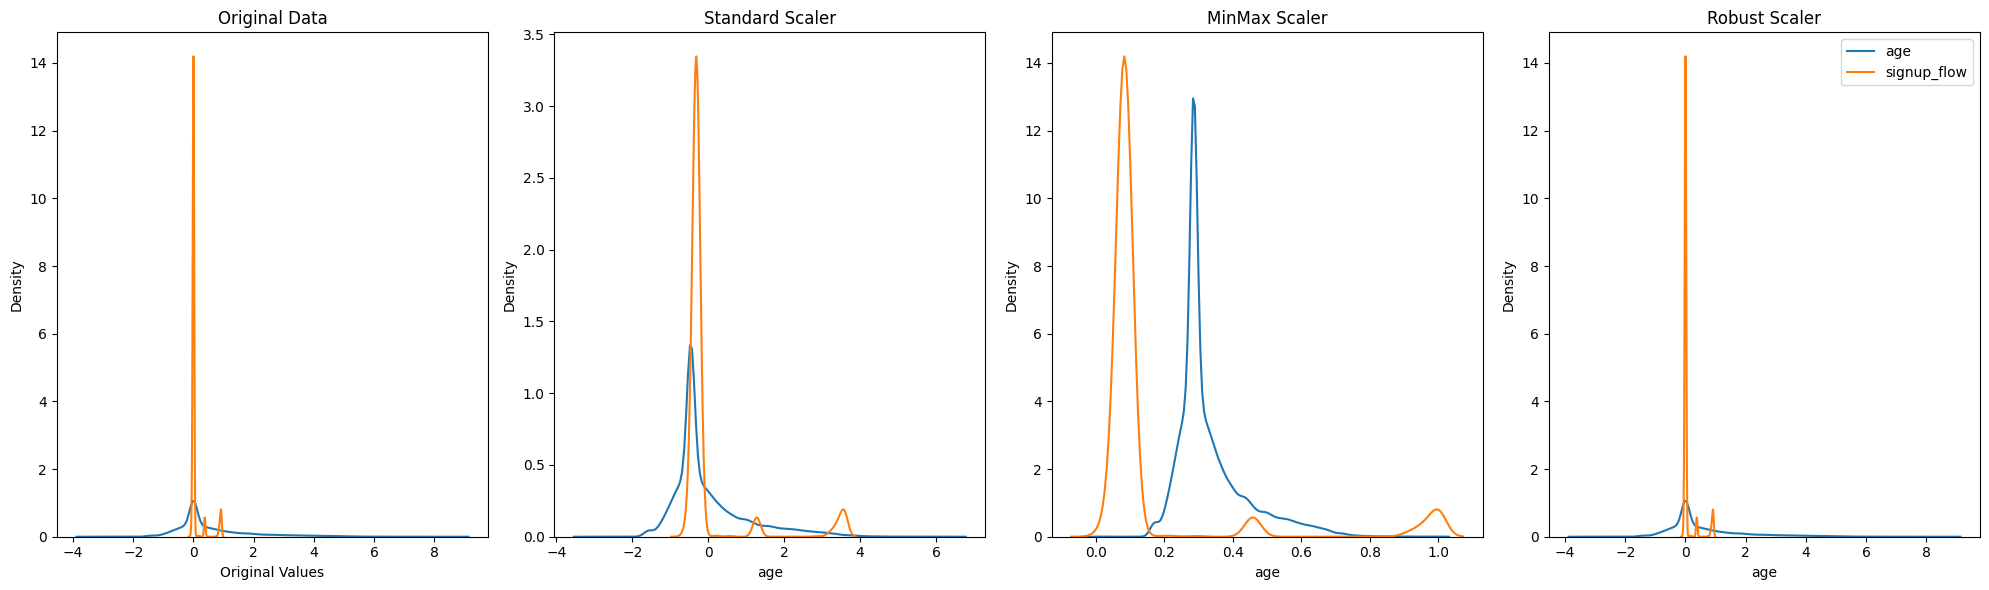

In [181]:
numeric_cols = ['age', 'signup_flow']

plt.figure(figsize=(20, 6))

# Original data
plt.subplot(1, 4, 1)
for column in numeric_cols:
  sns.kdeplot(train_data[column], label=column)
plt.xlabel('Original Values')
plt.title('Original Data')

scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
scaler_names = ['Standard', 'MinMax', 'Robust']

for i in range(3):
    scaler = scalers[i]
    scaled_data = pd.DataFrame(scaler.fit_transform(train_data[numeric_cols]), columns=numeric_cols)

    plt.subplot(1, 4, i+2)
    for column in numeric_cols:
        sns.kdeplot(scaled_data[column], label=column)
    plt.title('%s Scaler' % scaler_names[i])

plt.legend()
plt.tight_layout()
plt.show()

**Visualize k-fold courses using encoder, scaler, and model in Top 1**

In [187]:
def k_fold(df, model):
    # Extract columns to use
    use_columns = ['gender', 'age', 'language', 'signup_flow']
    target_column = ['country_destination']

    train_data = df.loc[:, use_columns]
    target_data = df.loc[:, target_column]

    X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.2, random_state=42)

    # Stratified K-Fold Cross Validation
    k_values = [3, 10, 50, 100]
    accuracy_scores = []

    for k in k_values:
        kf = KFold(n_splits=k, random_state=42, shuffle=True)
        fold_scores = []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            model.fit(X_train_fold, y_train_fold)

            y_val_pred = model.predict(X_val_fold)
            accuracy = accuracy_score(y_val_fold, y_val_pred)
            fold_scores.append(accuracy)

        average_accuracy = np.mean(fold_scores)
        accuracy_scores.append(average_accuracy)

    # Decision Model Evaluation
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Print accuracy scores
    print('\n======= Evaluate Model (K-Fold) =======')
    for k, accuracy in zip(k_values, accuracy_scores):
        print(f'Average Accuracy (Cross Validation) with k={k}: {accuracy}')
    print('Train Accuracy:', train_accuracy)
    print('Test Accuracy:', test_accuracy)
    print()

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        importance_feature_df = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("======= Feature Importance =======")
        print(importance_feature_df)
        print()

    # Plot accuracy scores
    plt.plot(k_values, accuracy_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by k in K-Fold Cross Validation')
    plt.show()

    # The predicted labels
    unique_labels, label_counts = np.unique(y_pred, return_counts=True)

    # Print predicted label counts
    for label, count in zip(unique_labels, label_counts):
        print(f"Label: {label}, Count: {count}")

    plt.figure(figsize=(8, 8))
    ax = sns.barplot(x=unique_labels, y=label_counts)
    ax.set_xlabel('Country Destination')
    ax.set_ylabel('Count')
    ax.set_title('Predicted Country Destination (K-Fold)')

    for i, count in enumerate(label_counts):
        ax.text(i, count, str(count), ha="center")

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_train, y_train_pred)

    # Print Confusion Matrix
    print("======= Confusion Matrix =======")
    print(cm)
    print()

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("======= Classification Report =======")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143


======= Evaluate Model (K-Fold) =======
Average Accuracy (Cross Validation) with k=3: 0.7020077650072452
Average Accuracy (Cross Validation) with k=10: 0.7020079404351133
Average Accuracy (Cross Validation) with k=50: 0.7020082470721608
Average Accuracy (Cross Validation) with k=100: 0.7020084664738698
Train Accuracy: 0.7020077046368417
Test Accuracy: 0.6998650320548869



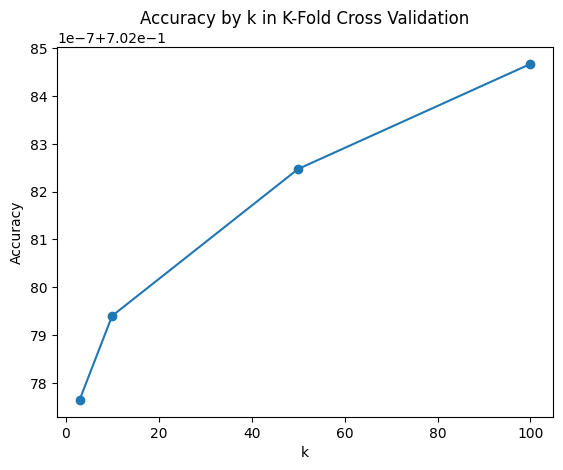

Label: US, Count: 17782


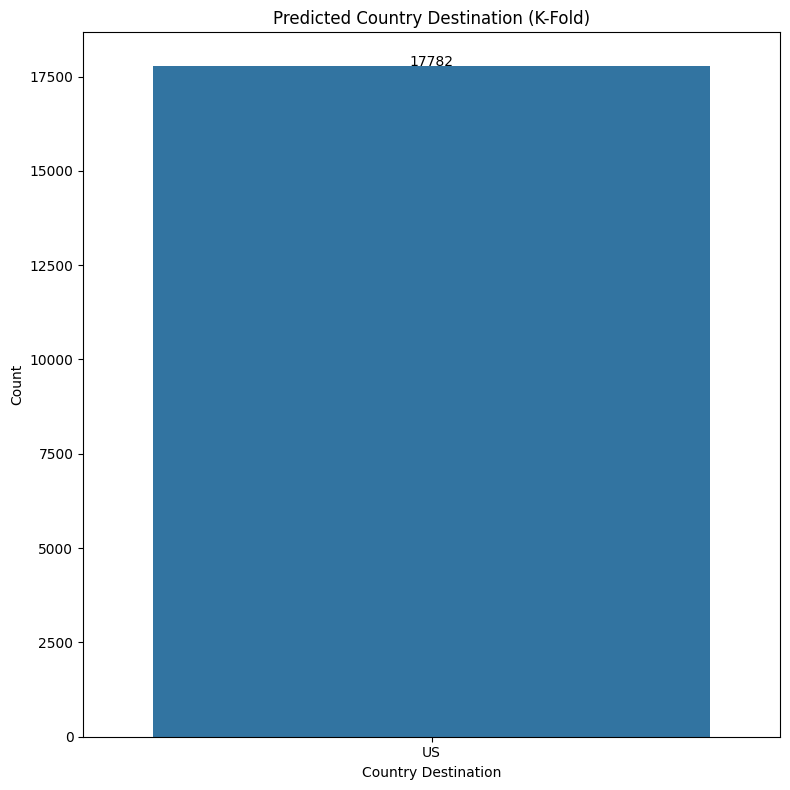

======= Confusion Matrix =======
[[    0     0     0     0     0     0     0     0     0   429     0]
 [    0     0     0     0     0     0     0     0     0  1161     0]
 [    0     0     0     0     0     0     0     0     0   833     0]
 [    0     0     0     0     0     0     0     0     0  1807     0]
 [    0     0     0     0     0     0     0     0     0  4020     0]
 [    0     0     0     0     0     0     0     0     0  1849     0]
 [    0     0     0     0     0     0     0     0     0  2266     0]
 [    0     0     0     0     0     0     0     0     0   601     0]
 [    0     0     0     0     0     0     0     0     0   171     0]
 [    0     0     0     0     0     0     0     0     0 49931     0]
 [    0     0     0     0     0     0     0     0     0  8058     0]]



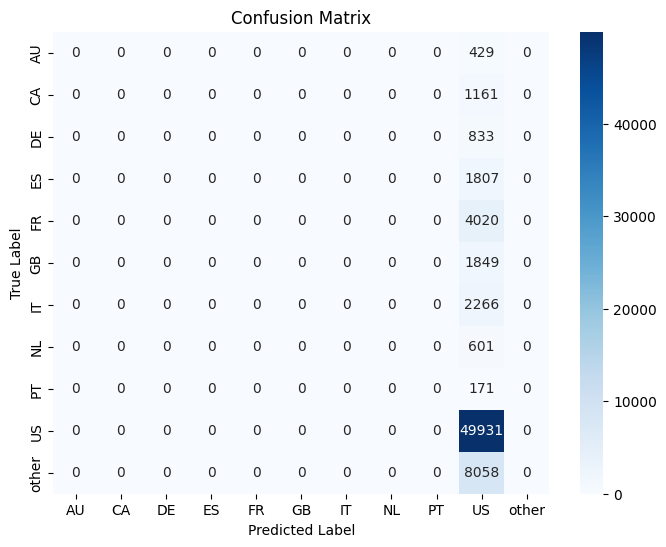

======= Classification Report =======


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       110
          CA       0.00      0.00      0.00       267
          DE       0.00      0.00      0.00       228
          ES       0.00      0.00      0.00       442
          FR       0.00      0.00      0.00      1003
          GB       0.00      0.00      0.00       475
          IT       0.00      0.00      0.00       569
          NL       0.00      0.00      0.00       161
          PT       0.00      0.00      0.00        46
          US       0.70      1.00      0.82     12445
       other       0.00      0.00      0.00      2036

    accuracy                           0.70     17782
   macro avg       0.06      0.09      0.07     17782
weighted avg       0.49      0.70      0.58     17782



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [188]:
df = mode(prep('train_users_2.csv'))
df = label_encoder(df)
df = standard_scaler(df)

k_fold(df, LogisticRegression(solver='liblinear'))


======= Evaluate Model (K-Fold) =======
Average Accuracy (Cross Validation) with k=3: 0.6954279051188706
Average Accuracy (Cross Validation) with k=10: 0.6964825668143232
Average Accuracy (Cross Validation) with k=50: 0.6963986961244493
Average Accuracy (Cross Validation) with k=100: 0.6965395707896775
Train Accuracy: 0.7060568568455979
Test Accuracy: 0.6937914745248004

======= Feature Importance =======
       feature  importance
1          age    0.532234
2     language    0.241961
3  signup_flow    0.141271
0       gender    0.084534



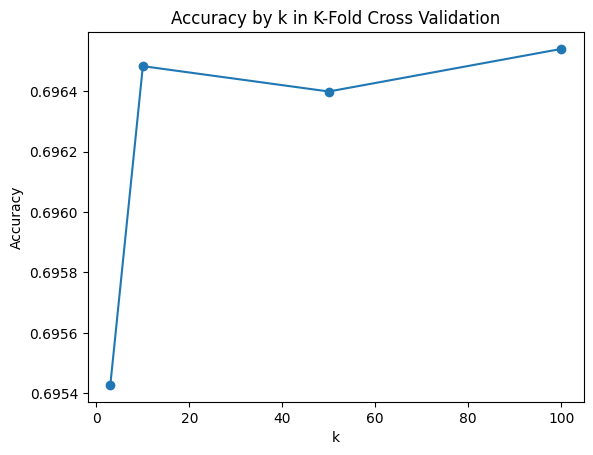

Label: AU, Count: 5
Label: CA, Count: 14
Label: DE, Count: 15
Label: ES, Count: 26
Label: FR, Count: 38
Label: GB, Count: 3
Label: IT, Count: 16
Label: NL, Count: 12
Label: US, Count: 17611
Label: other, Count: 42


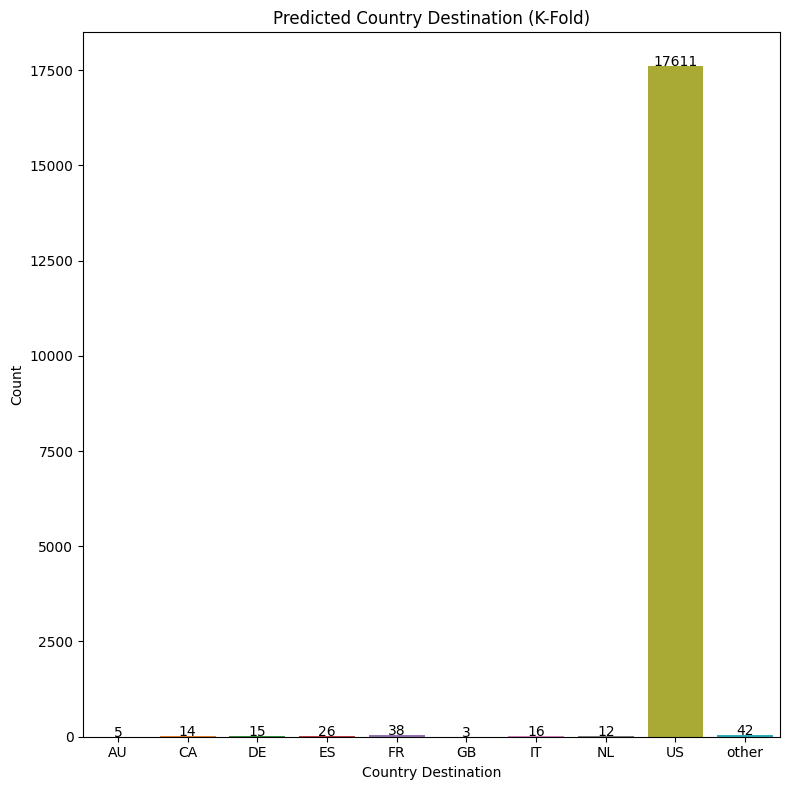

======= Confusion Matrix =======
[[    8     0     0     0     0     0     0     0     0   421     0]
 [    0    21     0     0     1     0     0     0     0  1139     0]
 [    0     0    27     0     0     0     0     0     0   805     1]
 [    1     0     1    51     1     0     0     0     0  1750     3]
 [    1     3     0     0    73     0     1     0     0  3939     3]
 [    0     2     1     0     5    25     0     0     0  1815     1]
 [    0     0     2     2     4     1    38     0     0  2216     3]
 [    0     0     0     1     0     0     0    17     0   583     0]
 [    0     0     0     0     0     0     1     0     3   166     1]
 [    4    12     9    14    27    13     7     9     1 49812    23]
 [    0     4     3     7     4     0     4     0     0  7892   144]]



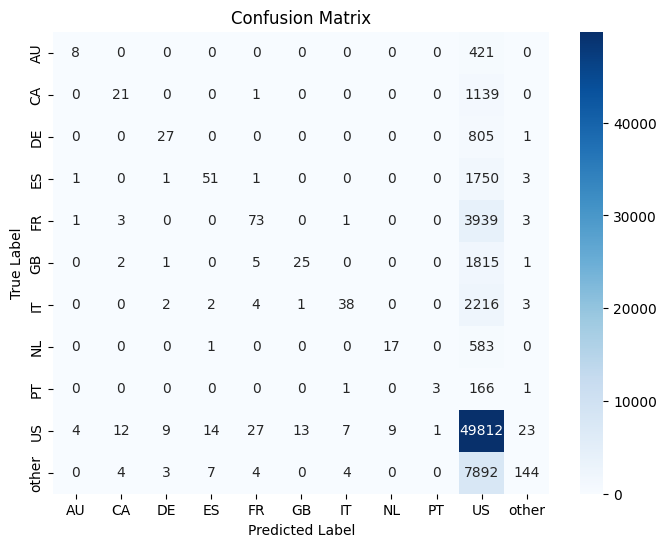

======= Classification Report =======


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       110
          CA       0.00      0.00      0.00       267
          DE       0.07      0.00      0.01       228
          ES       0.00      0.00      0.00       442
          FR       0.05      0.00      0.00      1003
          GB       0.33      0.00      0.00       475
          IT       0.12      0.00      0.01       569
          NL       0.00      0.00      0.00       161
          PT       0.00      0.00      0.00        46
          US       0.70      0.99      0.82     12445
       other       0.12      0.00      0.00      2036

    accuracy                           0.69     17782
   macro avg       0.13      0.09      0.08     17782
weighted avg       0.52      0.69      0.58     17782



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [189]:
df = mode(prep('train_users_2.csv'))
df = label_encoder(df)
df = standard_scaler(df)

k_fold(df, DecisionTreeClassifier())